# Importing Necessary Libraries

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

# Data Visualization

In [2]:
train = list(os.walk('../input/butterfly-classification-dataset/Train/Train')) #gives the list of all directories and subdirectories

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
dict_labels

{'pipevine swallow': 0,
 'grey hairstreak': 1,
 'malachite': 2,
 'cabbage white': 3,
 'copper tail': 4,
 'orange oakleaf': 5,
 'orange tip': 6,
 'southern dogface': 7,
 'sixspot burnet': 8,
 'american snoot': 9,
 'crimson patch': 10,
 'zebra long wing': 11,
 'great eggfly': 12,
 'gold banded': 13,
 'purple hairstreak': 14,
 'question mark': 15,
 'julia': 16,
 'orchard swallow': 17,
 'paper kite': 18,
 'sootywing': 19,
 'an 88': 20,
 'two barred flasher': 21,
 'clodius parnassian': 22,
 'red admiral': 23,
 'morning cloak': 24,
 'banded peacock': 25,
 'crecent': 26,
 'chestnut': 27,
 'indra swallow': 28,
 'viceroy': 29,
 'pine white': 30,
 'adonis': 31,
 'silver spot skipper': 32,
 'ulyses': 33,
 'black hairstreak': 34,
 'clouded sulphur': 35,
 'red spotted purple': 36,
 'straited queen': 37,
 'monarch': 38,
 'wood satyr': 39,
 'eastern coma': 40,
 'yellow swallow tail': 41,
 'beckers white': 42,
 'mangrove skipper': 43,
 'skipper': 44,
 'peacock': 45,
 'painted lady': 46,
 'scarce swall

In [4]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('../input/butterfly-classification-dataset/Train/Train')
images, labels = shuffle(images, labels)

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


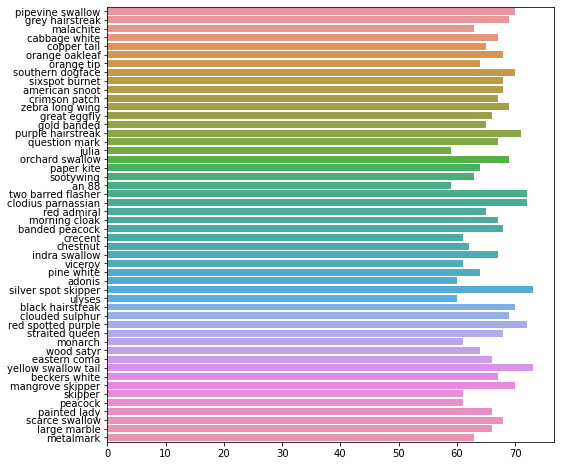

In [5]:
species = train[0][1]
no_of_butterflies = []
for _ in range(1, 51):
    no_of_butterflies.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = species, x = no_of_butterflies);

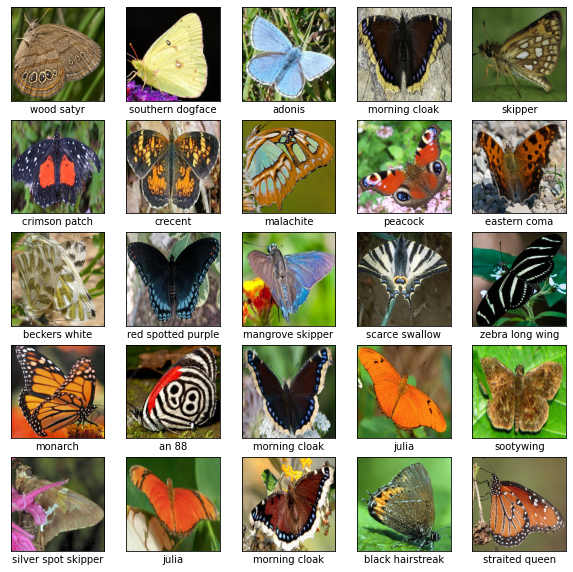

In [6]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

## Load images using ImageDatagenerator

In [7]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

train_ds = train_datagen.flow_from_directory('../input/butterfly-classification-dataset/Train/Train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('../input/butterfly-classification-dataset/Train/Train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 3601 images belonging to 50 classes.
Found 878 images belonging to 50 classes.


In [8]:
#this is for competition, where I had to predict the class of the given image
'''
test_datagen = ImageDataGenerator(rescale = 1./255)
test_ds = test_datagen.flow_from_directory('../input/butterfly-classification-dataset/Test',
                                          target_size = image_size,
                                          color_mode="rgb",
                                          class_mode = None,
                                          shuffle = False,
                                           batch_size = 50
                                          )
'''

'\ntest_datagen = ImageDataGenerator(rescale = 1./255)\ntest_ds = test_datagen.flow_from_directory(\'../input/butterfly-classification-dataset/Test\',\n                                          target_size = image_size,\n                                          color_mode="rgb",\n                                          class_mode = None,\n                                          shuffle = False,\n                                           batch_size = 50\n                                          )\n'

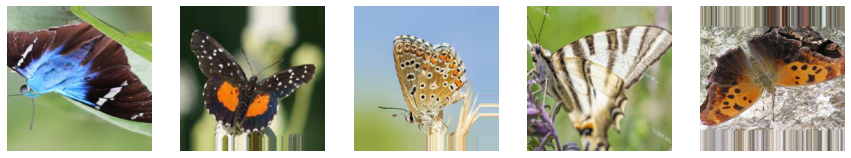

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# Transfer learning

### VGG16

In [10]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = vgg_base(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(50)(x)
model = keras.Model(inputs, outputs)

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                25650     
Total params: 14,740,338
Trainable params: 25,650
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
57/57 [==============================] - 90s 2s/step - loss: 3.8440 - categorical_accuracy: 0.0469 - val_loss: 3.6770 - val_categorical_accuracy: 0.1378
Epoch 2/20
57/57 [==============================] - 84s 1s/step - loss: 3.5567 - categorical_accuracy: 0.2199 - val_loss: 3.4489 - val_categorical_accuracy: 0.2460
Epoch 3/20
57/57 [==============================] - 85s 1s/step - loss: 3.3304 - categorical_accuracy: 0.3438 - val_loss: 3.2497 - val_categorical_accuracy: 0.3770
Epoch 4/20
57/57 [==============================] - 84s 1s/step - loss: 3.1207 - categorical_accuracy: 0.4468 - val_loss: 3.0513 - val_categorical_accuracy: 0.4704
Epoch 5/20
57/57 [==============================] - 84s 1s/step - loss: 2.9353 - categorical_accuracy: 0.5126 - val_loss: 2.9053 - val_categorical_accuracy: 0.5046
Epoch 6/20
57/57 [==============================] - 83s 1s/step - loss: 2.7771 - categorical_accuracy: 0.5296 - val_loss: 2.7491 - val_categorical_accuracy: 0.5330
Epoch 7/20
57/57